# Loading twitter bios

In [3]:
import pickle
with open('data/twitter_bios.pkl', 'rb') as f:
    bios = pickle.load(f)
    
bios[100:110]

[['"', 'economia', 'team manager'],
 ['socilogo', 'hincha de', 'sanlorenzo'],
 ['twitch affiliate',
  'k-pop',
  'taylor swift',
  'disney',
  'she',
  'her',
  'stan account'],
 ['business owner', 'atheist', 'music', 'vinyl junkie', 'caffeine addict'],
 ['god', 'freedom', 'justice', 'si vis pacem', 'para bellum'],
 ['investigator', 'wife', 'broncos', 'cyclones'],
 ['actor',
  'traveller',
  'writer',
  'producer',
  'director',
  'grampa',
  'photographer',
  'actuallyautistic'],
 ['documentary filmmaker', 'audio producer', 'editor', 'columbiajourn'],
 ['proud', 'vegan', 'novaccinepassports', 'ffs'],
 ['levi', 'devote', 'eng']]

In [4]:
print(len(bios))

3997690


# Cleaning data

## phrase cleaning

In [5]:
# build a vocabulary of phrases

from collections import Counter

pi_cnt = Counter()
for bio in bios:
    pi_cnt.update(bio)

len(pi_cnt)

37945

In [6]:
pi_cnt.most_common(5)

[('she', 511401),
 ('her', 434333),
 ('he', 261794),
 ('him', 215057),
 ('they', 163877)]

In [7]:
pi_cnt.most_common(len(pi_cnt))[-5:]

[('mo paz', 2),
 ('fala tu', 2),
 ('no bio yet', 2),
 ('lovely content', 1),
 ('skip for now', 1)]

## cleaning each bio

In [8]:
from tqdm import tqdm

# phrases of lenght at least 2
# profiles with at least 2 phrases

def clean_pis(all_pis):
    result = []
    for pis in tqdm(all_pis):
        current_pi = set()
        for pi in pis:
            if len(pi) >= 2 and pi_cnt[pi] >= 10:
                current_pi.add(pi)
        if len(current_pi) > 1:
            result.append(list(current_pi))
            
    return result
            
cleaned_bios = clean_pis(bios)
print(len(cleaned_bios))

100%|██████████| 3997690/3997690 [00:12<00:00, 310072.43it/s]

3971632


# Contrastive learning

## generating positive negative samples

In [68]:
# from each person's bio I create at most K triplets
from random import randint
import numpy as np

def pair_in_list(current_pair, l):
    for pair in l:
        if current_pair[0] in pair and current_pair[1] in pair:
            return True
    return False

def generate_triplets(bios, k=3):
    samples = []
    for idx, bio in tqdm(enumerate(bios), total=len(bios)):
        iters = min(len(bio)-1, k)
        chosen_pis = []
        for i in range(iters):
            pos1, pos2 = np.random.choice(bio, size=2, replace=False)
            while pair_in_list([pos1,pos2], chosen_pis):
                pos1, pos2 = np.random.choice(bio, size=2, replace=False)
                #print(pos1, pos2, chosen_pis, len(bio), bio)
            chosen_pis.append([pos1, pos2])
            neg_idx = randint(0, len(bios)-1)
            neg_sample = np.random.choice(bios[neg_idx], size=1)[0]
            samples.append([pos1, pos2, neg_sample])
    return samples
            
triplets = generate_triplets(cleaned_bios, k=3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971632/3971632 [07:26<00:00, 8904.14it/s]


## save dataset

In [69]:
import pickle 

with open('triplets.pkl', 'wb') as f:
    pickle.dump(triplets, f)

In [73]:
from sklearn.model_selection import train_test_split

train_set, valid_set = train_test_split(triplets, test_size=0.3, shuffle=True)

print(f"train size: {len(train_set)}, test size: {len(valid_set)}")

train size: 7171899, test size: 3073672


In [79]:
!mkdir data

In [84]:
!mkdir models

In [82]:
import csv

# writing the data into the file
with open('data/valid.csv', 'w') as f:   
    write = csv.writer(f, delimiter='\t')
    write.writerows(valid_set)
    
with open('data/train.csv', 'w') as f:   
    write = csv.writer(f, delimiter='\t')
    write.writerows(train_set)


## load dataset

In [7]:
import pickle 

with open('data/triplets.pkl', 'rb') as f:
    triplets = pickle.load(f)

## finetuning

### building the dataset


In [2]:
import csv
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

with open('data/train.csv', newline='') as f:
    train_examples = []
    reader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        train_examples.append(InputExample(texts=[row[0], row[1]], label=1.0))
        train_examples.append(InputExample(texts=[row[0], row[2]], label=0.0))
    

### loading evaluation dataset

In [3]:

from sentence_transformers import evaluation

with open('data/valid.csv', newline='') as f:
    sent1s = []
    sent2s = []
    scores = []
    i = 0
    reader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        sent1s.append(row[0])
        sent1s.append(row[0])
        sent2s.append(row[1])
        sent2s.append(row[2])
        scores.append(1.0)
        scores.append(0.0)
        if i > 30000:
            break
        i += 1
evaluator = evaluation.EmbeddingSimilarityEvaluator(sent1s, sent2s, scores)


### creating data loaders

In [4]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
dense_model = models.Dense(in_features=model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())
model.add_module('3', dense_model)

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=128)
train_loss = losses.CosineSimilarityLoss(model)

model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
  (3): Dense({'in_features': 384, 'out_features': 256, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

### training

In [ ]:
output_model_path = 'pi_model'

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=1,
          evaluation_steps=1000,
          warmup_steps=10000,
          output_path=output_model_path)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/112061 [00:00<?, ?it/s]

## evaluation

### loading saved model

In [203]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [204]:
from sentence_transformers import SentenceTransformer, models

model = SentenceTransformer('./models/')

model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

### calculating encodings for all phrases

In [205]:
pis = set()

for bio in cleaned_bios:
    pis.update(bio)

pis = list(pis)
print(len(pis))

embeddings = model.encode(pis, convert_to_tensor=True)
        

37831


In [206]:
import numpy as np

np.argsort(cosine_scores[10])[:-10]

array([ 0, 13,  7,  5,  6,  1])

In [207]:
def most_similar(pi, all_pis, all_pi_embs, model, k=11):
    cur_emb = model.encode(pi, convert_to_tensor=True)
    cosine_scores = util.cos_sim(cur_emb, all_pi_embs).detach().cpu().numpy()[0]
    most_similars = np.argsort(cosine_scores)[-k:]
    return [(all_pis[i], cosine_scores[i]) for i in most_similars if pi!=all_pis[i]]

most_similar('isfp', pis, embeddings, model, k=10)

[('infj-t', 0.9704561),
 ('infp-t', 0.97080636),
 ('isfj', 0.9721866),
 ('esfp', 0.9725394),
 ('infp', 0.97396433),
 ('isfj-t', 0.9744297),
 ('enfp-t', 0.9799815),
 ('esfp-t', 0.98076516),
 ('isfp-t', 0.9852693)]

In [208]:
def get_similarity(w1, w2, model=model):
    emb1 = model.encode(w1, convert_to_tensor=True)
    emb2 = model.encode(w2, convert_to_tensor=True)
    return util.cos_sim(emb1, emb2)

print(
    get_similarity('isfj', 'man'),
    get_similarity('isfj', 'woman'),
    get_similarity('isfj', 'man', model=base_model),
    get_similarity('isfj', 'woman', model=base_model),
)

print(
    get_similarity('intj', 'man'),
    get_similarity('intj', 'woman'),
    get_similarity('intj', 'man', model=base_model),
    get_similarity('intj', 'woman', model=base_model),
)

print(
    get_similarity('entj', 'man'),
    get_similarity('entj', 'woman'),
    get_similarity('entj', 'man', model=base_model),
    get_similarity('entj', 'woman', model=base_model),
)


tensor([[0.3405]], device='cuda:0') tensor([[0.4059]], device='cuda:0') tensor([[0.1651]], device='cuda:0') tensor([[0.1771]], device='cuda:0')
tensor([[0.4248]], device='cuda:0') tensor([[0.4971]], device='cuda:0') tensor([[0.2246]], device='cuda:0') tensor([[0.2016]], device='cuda:0')
tensor([[0.3892]], device='cuda:0') tensor([[0.4885]], device='cuda:0') tensor([[0.1872]], device='cuda:0') tensor([[0.1846]], device='cuda:0')


In [183]:
mom_emb = base_model.encode('intp', convert_to_tensor=True)
dad_emb = base_model.encode('esfj', convert_to_tensor=True)
util.cos_sim(mom_emb, dad_emb)

tensor([[0.1856]], device='cuda:0')

### loading not tuned model and doing the same thing

In [133]:
from sentence_transformers import SentenceTransformer, models

base_model = SentenceTransformer('all-MiniLM-L6-v2')
base_embs = base_model.encode(pis, convert_to_tensor=True)
base_cosine_scores = util.cos_sim(base_embs, base_embs).detach().cpu().numpy()

In [202]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

target_word = 'build the wall'
df1 = pd.DataFrame(most_similar(target_word, pis, embeddings, model), columns=['identifier', 'similarity'])
df1['model'] = 'fine-tuned-sentence-bert'
df2 = pd.DataFrame(most_similar(target_word, pis, base_embs, base_model), columns=['identifier', 'similarity'])
df2['model'] = 'original-sentence-bert'


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ax1.scatter(x=df1['identifier'], y=df1['similarity'])
ax1.tick_params(axis='x', rotation=-60)
ax1.set_xlabel('phrase')
ax1.set_ylabel('similarity')
ax1.set_title('fine-tuned-sentence-bert')


ax2.scatter(x=df2['identifier'], y=df2['similarity'])
ax2.tick_params(axis='x', rotation=-60)
ax2.set_xlabel('phrase')
ax2.set_ylabel('similarity')
ax2.set_title('original-sentence-bert')

plt.show()

AttributeError: 'KeyedVectors' object has no attribute 'encode'

### analyzing personalities

In [139]:
for personality in ['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ', 'ESTP', 'ESFP', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'INTP', 'INFP']:
    if personality in pis or personality.lower() in pis:
        print(f"{personality}: True")
    else:
        print(f"{personality}: False")

ESTJ: True
ENTJ: True
ESFJ: True
ENFJ: True
ISTJ: True
ISFJ: True
INTJ: True
INFJ: True
ESTP: True
ESFP: True
ENTP: True
ENFP: True
ISTP: True
ISFP: True
INTP: True
INFP: True


In [179]:
personalities = ['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ', 'ESTP', 'ESFP', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'INTP', 'INFP']
personalities = [p.lower() for p in personalities]

pers_emb = model.encode(personalities, convert_to_tensor=True)
pers_emb_base = base_model.encode(personalities, convert_to_tensor=True)

base_cosine_scores = util.cos_sim(pers_emb_base, pers_emb_base).detach().cpu().numpy()
cosine_scores = util.cos_sim(pers_emb, pers_emb).detach().cpu().numpy()

[Text(0, 0.5, 'estj'),
 Text(0, 1.5, 'entj'),
 Text(0, 2.5, 'esfj'),
 Text(0, 3.5, 'enfj'),
 Text(0, 4.5, 'istj'),
 Text(0, 5.5, 'isfj'),
 Text(0, 6.5, 'intj'),
 Text(0, 7.5, 'infj'),
 Text(0, 8.5, 'estp'),
 Text(0, 9.5, 'esfp'),
 Text(0, 10.5, 'entp'),
 Text(0, 11.5, 'enfp'),
 Text(0, 12.5, 'istp'),
 Text(0, 13.5, 'isfp'),
 Text(0, 14.5, 'intp'),
 Text(0, 15.5, 'infp')]

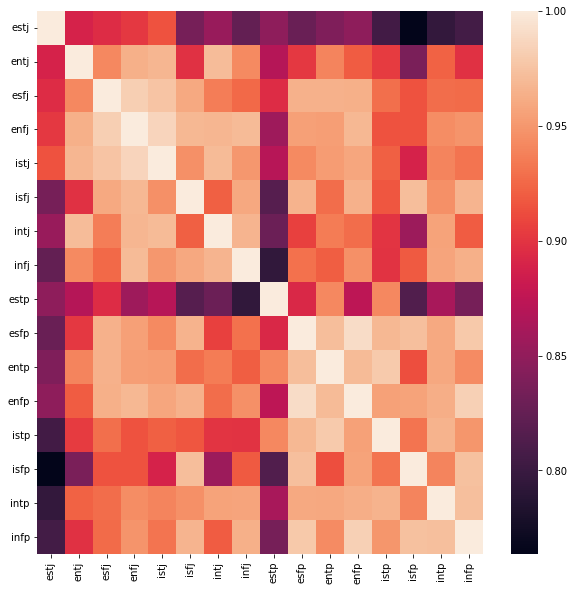

In [180]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_scores)
ax.set_xticklabels(personalities, rotation=90)
ax.set_yticklabels(personalities, rotation=0)

# plt.xticks(ticks=personalities)
# plt.yticks(ticks=personalities)

[Text(0, 0.5, 'estj'),
 Text(0, 1.5, 'entj'),
 Text(0, 2.5, 'esfj'),
 Text(0, 3.5, 'enfj'),
 Text(0, 4.5, 'istj'),
 Text(0, 5.5, 'isfj'),
 Text(0, 6.5, 'intj'),
 Text(0, 7.5, 'infj'),
 Text(0, 8.5, 'estp'),
 Text(0, 9.5, 'esfp'),
 Text(0, 10.5, 'entp'),
 Text(0, 11.5, 'enfp'),
 Text(0, 12.5, 'istp'),
 Text(0, 13.5, 'isfp'),
 Text(0, 14.5, 'intp'),
 Text(0, 15.5, 'infp')]

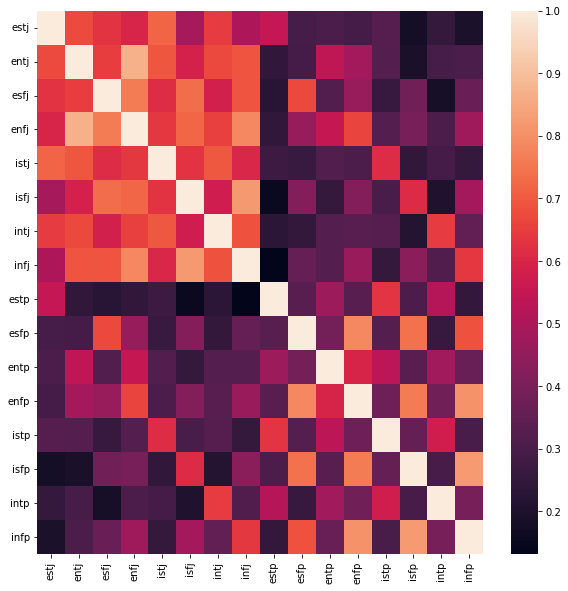

In [181]:
plt.figure(figsize=(10,10))

ax = sns.heatmap(base_cosine_scores)
ax.set_xticklabels(personalities, rotation=90)
ax.set_yticklabels(personalities, rotation=0)

### comparing in gensim vocab

In [210]:
import gensim.downloader as api

w2v = api.load("glove-wiki-gigaword-50")
w2v.most_similar("glass")

[('plastic', 0.7942506074905396),
 ('metal', 0.770871639251709),
 ('walls', 0.7700635194778442),
 ('marble', 0.7638523578643799),
 ('wood', 0.7624281048774719),
 ('ceramic', 0.7602593302726746),
 ('pieces', 0.7589111328125),
 ('stained', 0.7528817653656006),
 ('tile', 0.748193621635437),
 ('furniture', 0.7463858723640442)]

In [214]:
vocab = list(w2v.key_to_index.keys())

vocab_embs = model.encode(vocab, convert_to_tensor=True)


In [215]:
most_similar('vaccine', vocab, vocab_embs, model, k=10)

[('cleanfeed', 0.9399279),
 ('overdevelopment', 0.94011027),
 ('hindering', 0.94033366),
 ('averts', 0.94081146),
 ('regasification', 0.9420348),
 ('dods', 0.9421477),
 ('counterproposal', 0.9423385),
 ('rediscounting', 0.94654495),
 ('backpropagation', 0.9470374)]

In [220]:
most_similar('blm', vocab, vocab_embs, model, k=50)

[('retooled', 0.9054919),
 ('kapova', 0.90612507),
 ('dykema', 0.90841216),
 ('f-fdtl', 0.9097182),
 ('trans-texas', 0.90972906),
 ('jdrew', 0.9107921),
 ('transgendered', 0.91270465),
 ('reflagged', 0.9133766),
 ('fdlr', 0.91347164),
 ('anti-white', 0.91363406),
 ('shpigel', 0.91434467),
 ('defatted', 0.9144651),
 ('fdtd', 0.9154509),
 ('bdt', 0.9161978),
 ('trans-pecos', 0.91632265),
 ('dembo', 0.91688424),
 ('demby', 0.91711247),
 ('re-union', 0.9184007),
 ('flnc', 0.9196488),
 ('anti-black', 0.9198113),
 ('yippie', 0.9204249),
 ('sliwa', 0.9211106),
 ('demaree', 0.9251369),
 ('kapow', 0.9274084),
 ('transmigrants', 0.92956984),
 ('fdtl', 0.93025285),
 ('black-majority', 0.93315375),
 ('abolish', 0.93458647),
 ('abolishing', 0.9362927),
 ('ftp', 0.9390266),
 ('abolishment', 0.940132),
 ('demsey', 0.9404614),
 ('defund', 0.94085896),
 ('abolishes', 0.94256717),
 ('transwede', 0.9428791),
 ('rtlm', 0.94452107),
 ('pro-drop', 0.9445965),
 ('slumdwellers', 0.9494755),
 ('gnc', 0.9648286

# Word2vec embedding

In [ ]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

print(len(sentences))

class Callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

monitor = Callback()
model = Word2Vec(sentences, vector_size=50, window=5, min_count=1,
                 negative=10, workers=30, epochs=50, callbacks=[monitor],
                 compute_loss=True)

model.save('./w2v.model')

In [7]:
model = Word2Vec.load("./w2v.model")

In [8]:
model.wv.most_similar('he', topn=15)

[('pronouns: he', 0.9228585958480835),
 ('pronouns he', 0.8569645881652832),
 ('cis he', 0.8101291656494141),
 ('pronouns are he', 0.7875774502754211),
 ('them or he', 0.7698878645896912),
 ('my pronouns are he', 0.7616384625434875),
 ('them he', 0.7570477724075317),
 ('21 he', 0.6931623220443726),
 ('18 he', 0.6897026300430298),
 ('24 he', 0.6832929849624634),
 ('blm he', 0.6671035289764404),
 ('19 he', 0.6558746695518494),
 ('22 he', 0.627196192741394),
 ('23 he', 0.6264557838439941),
 ('20 he', 0.6185081005096436)]